# Overfitting

<!-- <a href="https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics)">Wikipedia</a>
[Polynomial 수식 유도](http://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html)
-->

Overfitting은 주어진 데이터로 모델을 학습할 때 발생하는 대표적인 걸림돌이다. 한정되고 노이즈가 섞인 데이터로 모델을 학습하다보니, 주어진 학습데이터에만 과도하게(over) fitting 되어 실제 정확도는 나빠지게 되는 현상을 말한다. 가장 간단한 linear least square 모델을 사용해 overfitting이 발생하는 것을 관찰해보고, overfitting을 막을 수 있는 다양한 방법들을 살펴보자.

In [1]:
# https://en.wikipedia.org/wiki/Linear_least_squares_(mathematics)
# http://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html
#Motivational_example

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# retrun: [1 x x^2 ... x^k] (shape= (N,1+k))
def buildX(x, k):
    x = np.array(x) if type(x) is list else x
    X = np.ones_like(x)
    #X = np.ones(len(x), 1)
    
    for i in range(k):
        X = np.vstack((X, np.power(x, i + 1)))
    
    return X.T

# return: compute polynomial (shape= (N,1))
def evaluate(a, x):
    y = np.zeros(x.shape[0])
    
    for i in range(a.shape[0]):
        y += a[i] * np.power(x, i)
        
    return y

# return: sum of squred error (shape= (1,1))
def sqrErr(d, o):
    return np.sum(np.power(d - o, 2), 0) / 2.

def fit(X, y):
    
    a = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return a

def plot(x, y, a, rangeX, ax=None):
    
    if len(np.array(a).shape) == 0:
        k = 0
    else:
        k = a.shape[0] - 1;
    
    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    ax.set_title(u'Fit Polynomial Fn, $k = %d$' % k, fontsize=20)
    ax.set_xlabel(u'$x$', fontsize=15)
    ax.set_ylabel(u'$y$', fontsize=15, rotation='horizontal')
    ax.text(1.05, 1, '\n'.join('$a_%d = %f$' % (i, a[i]) for i in range(k+1)), 
            transform=ax.transAxes, verticalalignment='top', fontsize=15)

    xx = np.linspace(rangeX[0], rangeX[1])
    yy = evaluate(a, xx)
    ax.plot(xx, yy, color='b')

    ax.scatter(x, y, color='r')
    
    o = evaluate(a, x)
    
    err = sqrErr(y, o)
    
    ax.text(0.5, 0.9, u'$E = %f$' % err, fontsize=15, transform=ax.transAxes)
    
    return ax

def plot_f(f, rangeX, ax):
    xx = np.linspace(rangeX[0], rangeX[1])
    yy = f(xx)
    ax.plot(xx, yy, color='g')

In [2]:
def generateData(N, f, rangeX=[-5, 5], noiseLv = 0.1):
    x = np.random.rand(N) * (rangeX[1] - rangeX[0]) + rangeX[0]
    
    noise = np.random.randn(N) * noiseLv
    y = f(x) + noise
    
    return x, y


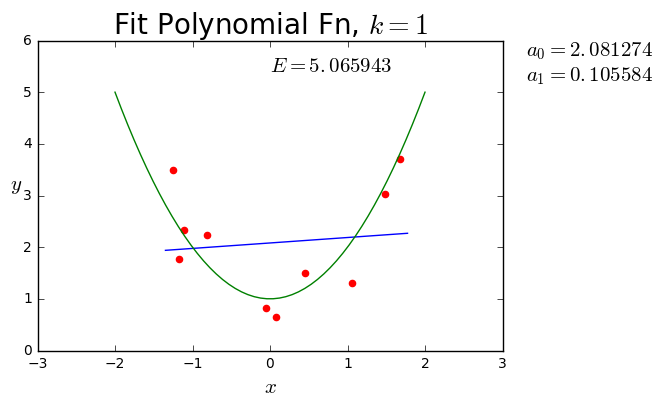

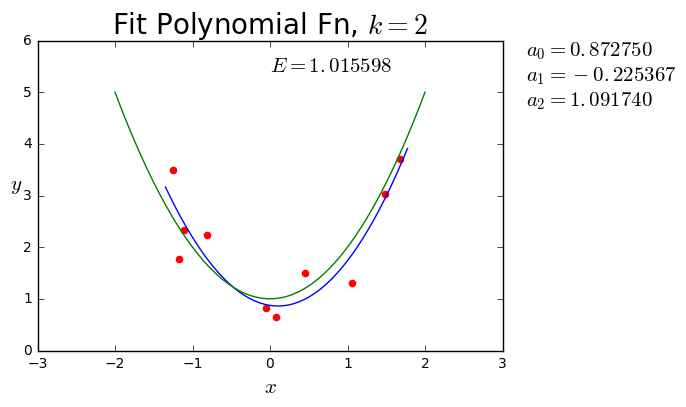

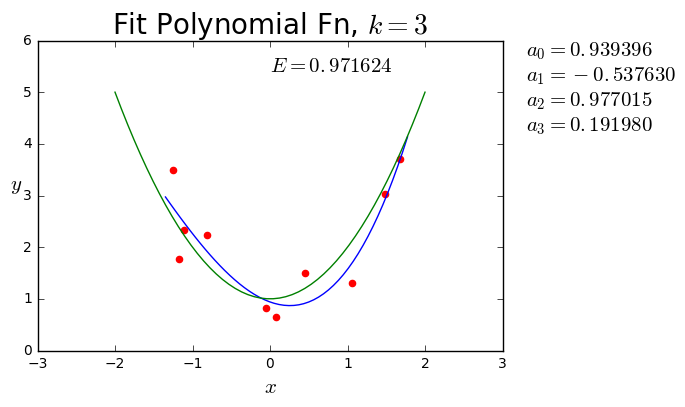

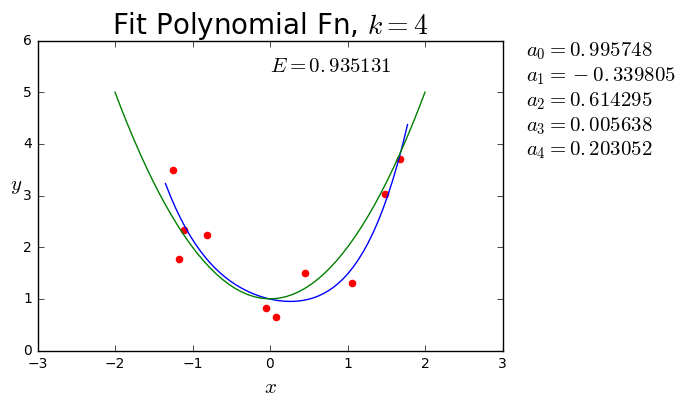

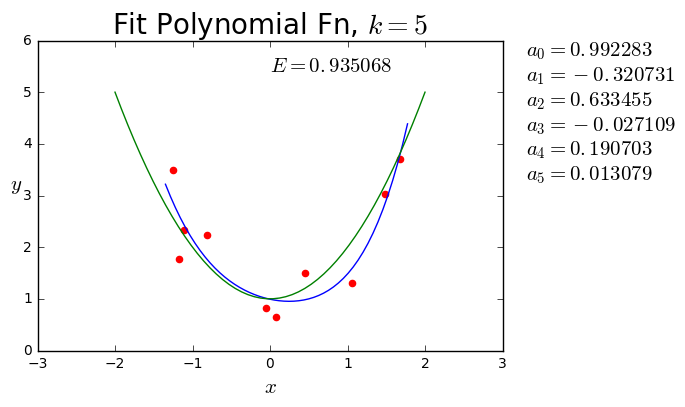

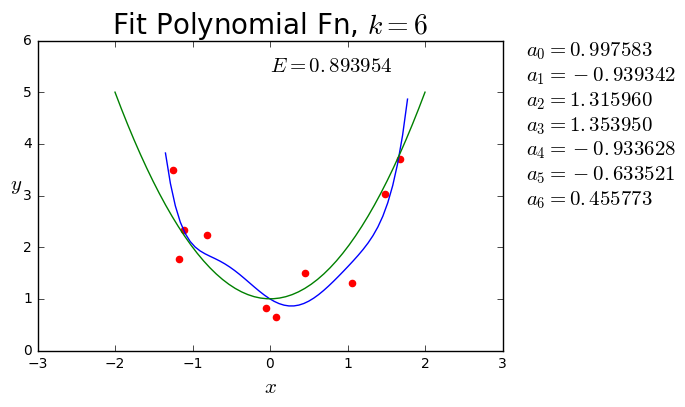

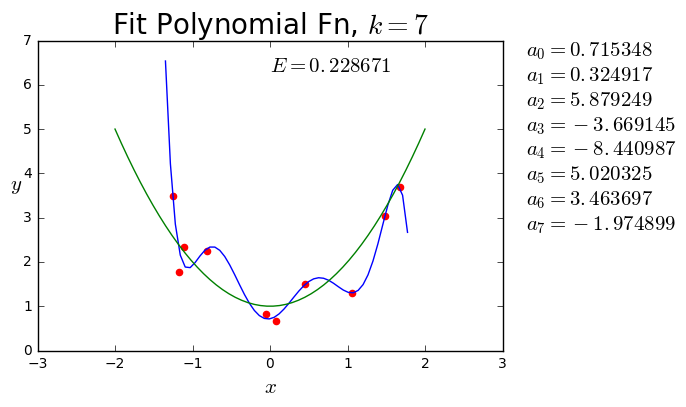

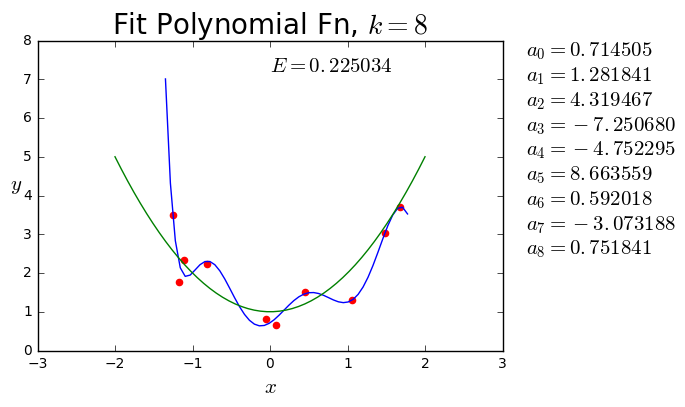

In [4]:
N = 10
f = lambda x: x ** 2 + 1
rangeX = [-2, 2]
np.random.seed(5)
x, y = generateData(N, f, rangeX=rangeX, noiseLv=0.5)



K = 8

for k in range(1, K+1):
    X = buildX(x, k)
    
    a = fit(X, y)
    #a = fit_GD(X, y, 10000, 0.00001, 0.5)
    
    ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
    plot_f(f, rangeX=rangeX, ax=ax)

## 현상

* 데이터 포인트와의 오차(E)는 줄어드는데, 원래 함수와는 점점 더 멀어진다.
* 함수가 복잡할 수록 더 심하다.
* 함수의 차수가 데이터 개수와 비슷해지자 확 심해진다.
* Parameter가 과도하게 크다.

### 대책1: Best Model
딱 알맞은 정도로 모델의 복잡도를 설정한다.


### 대책2: More Data
데이터가 더 많으면 괜찮아진다.
N=100으로 해서 돌려보자

### 대책3: Early stop
parameter가 과하게 커지기 전에 중단하자!

In [5]:
from numpy.testing import assert_array_almost_equal as assertEqual

def lossFn(X, y, a):
    if len(X.shape) == 1:
        f = X * a
    else:
        f = evaluate(a, np.array(X[:,1]))
        
    E = sqrErr(f,y)
    return E

def grad(X, y, a):
    if len(X.shape) == 1:
        f = X * a
    else:
        f = np.dot(X,a)
        
    e = y - f
    
    gradE = - e.T.dot(X).T
    
    return gradE


def fit_GD(X, y, epoch, mu, momentum = 0):
    
    if len(X.shape) == 1:
        a = np.random.randn() * 0.01
    else:
        a = np.random.randn(X.shape[1]) * 0.01
    
    E = 0
    
    prevDelta = 0
    for i in range(epoch):
        
        #if (i % (epoch / 10) == 0):
        #    print lossFn(X,y,a)
        
        gradE = grad(X,y,a)
        
        delta = mu * gradE + momentum * prevDelta
        a -= delta

        prevDelta = delta
    
    return a


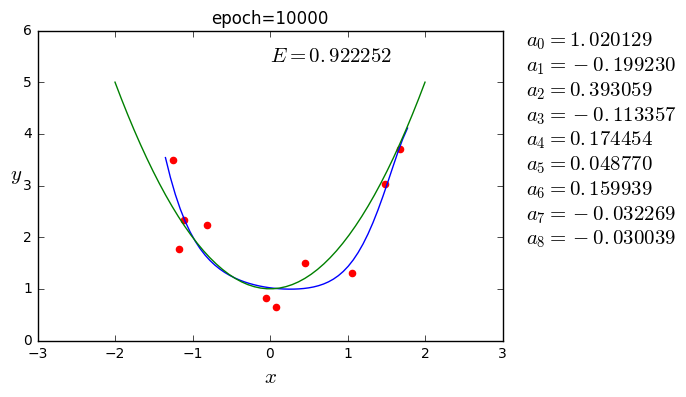

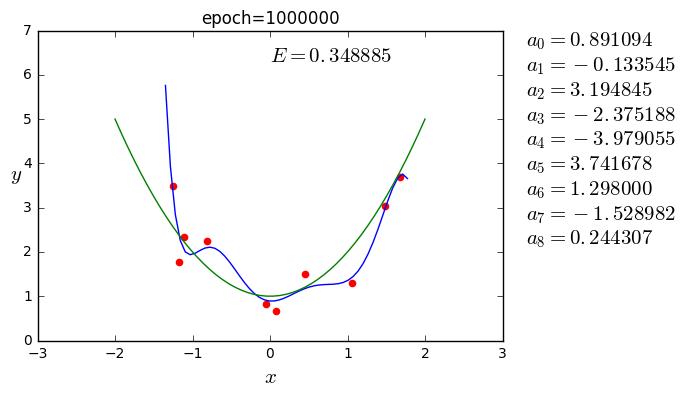

In [6]:
k = 8

X = buildX(x, k)

a = fit_GD(X, y, 10000, 0.0001, 0)

ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
ax.set_title('epoch=10000')
plot_f(f, rangeX=rangeX, ax=ax)

a = fit_GD(X, y, 1000000, 0.0001, 0)

ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
ax.set_title('epoch=1000000')
plot_f(f, rangeX=rangeX, ax=ax)

### 대책4: Regularization
파라미터가 못 커지게 하자!

loss function에 파라미터가 커지면 값이 커지게 하는 페널티를 준다.

$$ E_{L_1} = E + \lambda \sum \left| a_i \right| $$
$$ E_{L_2} = E + \lambda \sum a_i ^ 2$$

In [7]:
def lossFn_L2(X, y, a, lam):
    if len(X.shape) == 1:
        f = X * a
        sumA = a ** 2
    else:
        f = evaluate(a, np.array(X[:,1]))
        sumA = np.sum(np.power(a, 2))
        
    E = sqrErr(f,y) + lam * sumA
    return E

def grad_L2(X, y, a, lam):
    if len(X.shape) == 1:
        f = X * a
    else:
        f = np.dot(X,a)
        
    e = y - f
    
    gradE = - e.T.dot(X).T + 2 * lam * a
    
    return gradE 

def fit_GD_L2(X, y, epoch, mu, lam = 0, momentum = 0):
    
    if len(X.shape) == 1:
        a = np.random.randn() * 0.01
    else:
        a = np.random.randn(X.shape[1]) * 0.01
    
    E = 0
    
    prevDelta = 0
    for i in range(epoch):
        
        #if (i % (epoch / 10) == 0):
        #    print lossFn_L2(X,y,a,lam)
        
        gradE = grad_L2(X,y,a,lam)
        
        delta = mu * gradE + momentum * prevDelta
        a -= delta

        prevDelta = delta
    
    return a

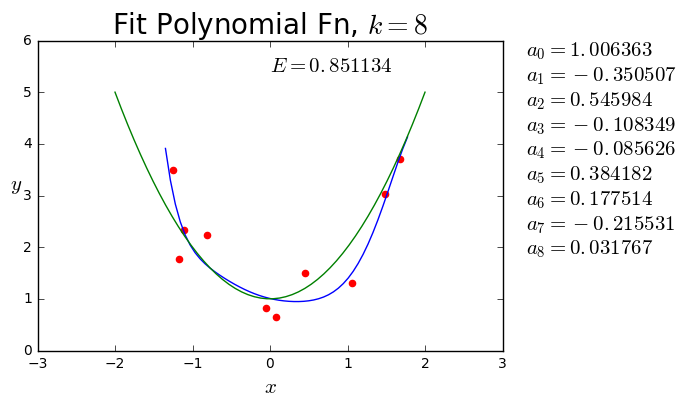

In [8]:
k = 8

X = buildX(x, k)

a = fit_GD_L2(X, y, 1000000, 0.0001, 0.1)

ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
plot_f(f, rangeX=rangeX, ax=ax)

## Test Data & Validation Data

Overfitting 대책 중에서, Best Model을 찾거나 Early Stop 하려면 데이터의 원래 함수(녹색 선)을 알고 있어야 하는데, 이건 알 수 없는 건데? 정답을 알고 있는데 fitting을 왜 하고 있겠냐?

-> 학습된 모델을 평가할 때는 학습 데이터와 같은 함수에서 뽑아낸 (뽑아 냈다고 생각되는) 다른 데이터 셋을 사용하자!

- Test dataset : 학습이 끝난 모델을 평가할 때 사용
- Validataion dataset: 학습 중에 모델을 평가할 때 사용

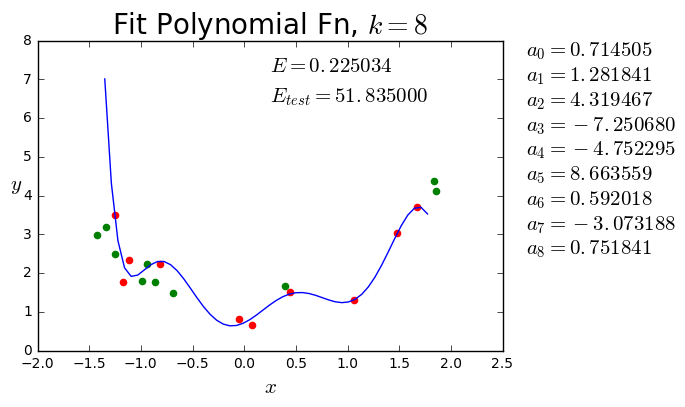

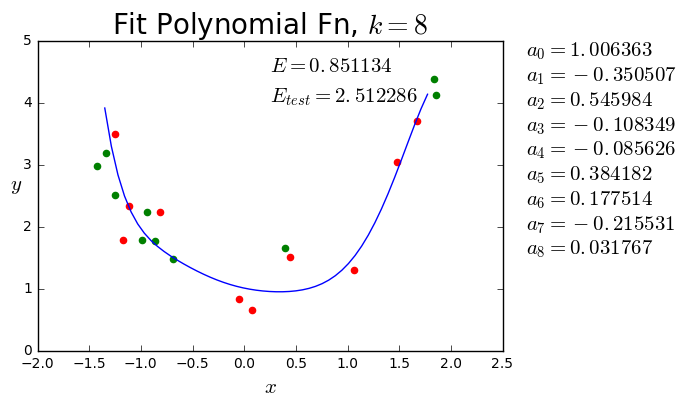

In [9]:
N = 10
f = lambda x: x ** 2 + 1
rangeX = [-2, 2]
np.random.seed(5)
x, y = generateData(N, f, rangeX=rangeX, noiseLv=0.5)
testX, testY = generateData(N, f, rangeX=rangeX, noiseLv=0.5)

a = fit(X, y)

testE = lossFn(buildX(testX,k), testY, a)
ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
ax.scatter(testX, testY, color='g')
ax.text(0.5, 0.8, u'$E_{test} = %f$' % testE, fontsize=15, transform=ax.transAxes)


a = fit_GD_L2(X, y, 1000000, 0.0001, 0.1)

testE = lossFn(buildX(testX,k), testY, a)
ax = plot(x, y, a, rangeX=[min(x) - 0.1, max(x) + 0.1])
ax.scatter(testX, testY, color='g')
ax.text(0.5, 0.8, u'$E_{test} = %f$' % testE, fontsize=15, transform=ax.transAxes)


# Curse of Dimensionality 

[**차원의 저주**](https://en.wikipedia.org/wiki/Curse_of_dimensionality)는 고차원 데이터를 다룰 때 발생하는, 하지만 저차원에서 발생하지 않는 골 때리는 현상들을 종합해 부르는 말이다. 

분야에 따라 다양한 현상들이 있는데, 가장 쉬운 예로는 탐색이 있다. 당신이 USB 드라이브를 잃어버렸다고 하자. 100m 길이의 길에서 떨어뜨렸다면, 2~3분안에 찾을 수 있을 것이다. 100제곱미터 너비의 운동장에서 잃어버렸다면, 몇 시간이 걸리 수도 있다. 그런데 만약 100세제곱미터 규모의 30층짜리 빌딩에서 잃어버렸다면? 며칠은 걸려야 찾을 수 있을 것이다. 


기계학습 기법에서는 모든 데이터를 벡터로 바꿔 사용한다. [28, '남성', '학사'] => [0.28, 0, 3] 이렇게 말이다. 벡터로 변환된 데이터 포인트는 좌표 공간에 표시되는데, 대부분의 기계학습은 **"비슷한 데이터 포인트끼리는 가까이 있을 것이다"**라는 가정을 깔고 있다. 그래서 새로운 데이터 포인트의 성질을 알고 싶은 때에는 가장 가까운 포인트를 찾아서 그 포인트의 성질로 판단한다.

그런데, **데이터의 차원이 증가할 때, 데이터 포인트 사이의 거리의 분포**는 어떻게 변할까?

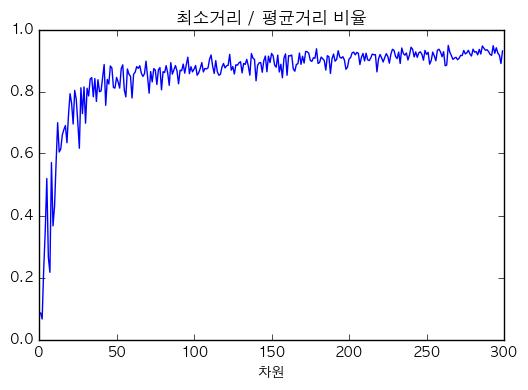

In [62]:
'''
from http://lgatto.github.io/curse-dimensionality/
'''
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc("font", family="AppleGothic")

def sample(d=2, N=10):
    '''
    d 차원의 데이터 포인트를 N 개 만들어 리스트로 반환한다.
    '''
    return [[np.random.uniform(0., 1.) for i in range(d)] for _ in range(N)]

#def corner_count(points):
#    return np.mean([any([(d < .01 or d > .99) for d in p]) for p in points])

def min_avg_distance_ratio(points):
    '''
    입력받은 데이터 포인트들(points)사이의 최소거리와 평균거리를 구하고 
    '''
    p = np.asarray(points)
    dist = [np.linalg.norm(p[i,:]-p[j,:]) for i in range(p.shape[0]-1) for j in range(i+1, p.shape[0])]
    return np.min(dist) / np.mean(dist)

def go(Ds=range(1,300)):
    #plt.plot(Ds, [corner_count(sample(d)) for d in Ds])
    
    ax = plt.figure().add_subplot(111)
    ax.plot(Ds, [min_avg_distance_ratio(sample(d)) for d in Ds])
    ax.set_title(u'최소거리 / 평균거리 비율')
    ax.set_xlabel(u'차원')

go()

위의 그래프에서 확인할 수 있듯이, 차원이 증가함에 따라 무작위로 생성된 포인트 간의 최소거리와 평균거리의 차이가 거의 사라지고 있다. 다시 말해 차원이 증가할 수록 **가장 비슷한 데이터 포인트와 전혀 상관없는 데이터 포인트 사이의 거리가 별 차이 없어진다**는 것이다. 이런 고차원 데이터에 대해서는 KNN과 같이 단순히 거리에 기반해 판단하는 기계학습 기법은 힘을 못쓴다. **차원축소(Dimensionality Reduction)** 기법을 사용해 의미있는 차원만 먼저 뽑아내거나, **SVM** 이나 **Deep Network** 같이 고차원 데이터에 강한 기법을 골라서 사용해야 한다.